In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Load data
df = pd.read_csv("./output/jpm_retail_portfolio_raw.csv")

# Convert Quarter/Year to datetime
df['Quarter_dt'] = pd.PeriodIndex(df['Quarter'], freq='Q').to_timestamp()

# Check duplicates
duplicates = df[df.duplicated(subset=['Quarter_dt', 'Metric'], keep=False)]

print("Number of duplicate rows:", len(duplicates))
print(duplicates.sort_values(['Quarter_dt', 'Metric']))

Number of duplicate rows: 0
Empty DataFrame
Columns: [Metric, Quarter, Value, Quarter_dt]
Index: []


In [26]:
# Pivot to wide format
df_wide = df.pivot(index='Quarter_dt', columns='Metric', values='Value')

# Sort
df_wide = df_wide.sort_index()

# Basic check
print(df_wide["Allowance for credit losses"])
# print(df_wide.isna().sum())

Quarter_dt
2009-01-01      28019
2009-04-01      29818
2009-07-01      31454
2009-10-01      32541
2010-01-01      39126
               ...   
2024-04-01    25514.0
2024-07-01      26543
2024-10-01      26866
2025-01-01      27835
2025-04-01    28281.0
Name: Allowance for credit losses, Length: 63, dtype: object


In [27]:
stable_vars = [
    "Loans", "Deposits", "Total assets", "Long-term debt",
    "Common stockholders’ equity", "Total net revenue",
    "Total noninterest expense", "Net income",
    "Income before income tax expense",
    "Income tax expense", "Pre-provision profit",
    "Net charge-offs", "Net charge-off rate", "Allowance for credit losses"
]

df_wide[stable_vars] = df_wide[stable_vars].ffill()

df_wide["CET1_combined"] = df_wide["Common equity Tier 1 (“CET1”) capital ratio"]

df_wide["CET1_combined"] = df_wide["CET1_combined"].fillna(
    df_wide["Tier 1 common capital ratio"]
)

df_wide.drop(columns=["Tier 1 common capital ratio","Common equity Tier 1 (“CET1”) capital ratio","Consumer net charge-off rate","Common stockholders’ equity","Income before income tax expense"], inplace=True)
print(df_wide.isna().sum())

Metric
Allowance for credit losses                          0
Allowance for loan losses to total retained loans    0
Deposits                                             0
Income tax expense                                   0
Loans                                                0
Long-term debt                                       0
Net charge-off rate                                  0
Net charge-offs                                      0
Net income                                           0
Nonperforming assets                                 0
Pre-provision profit                                 0
Provision for credit losses                          0
Tier 1 capital ratio                                 0
Tier 1 leverage ratio                                0
Total assets                                         0
Total capital ratio                                  0
Total net revenue                                    0
Total noninterest expense                            0
CET

In [30]:
for col in df_wide.columns:
    if df_wide[col].astype(str).str.contains('%').any():
        print(col)

for col in df_wide.columns:
    if df_wide[col].dtype == 'object':
        df_wide[col] = (
            df_wide[col]
            .astype(str)
            .str.replace('%', '', regex=False)
            .str.replace(',', '', regex=False)
        )
        df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce') / 100

Allowance for loan losses to total retained loans
Net charge-off rate
CET1_combined


In [31]:
## Summary statistics

summary_stats = df_wide.describe().T
summary_stats['skew'] = df_wide.skew()
summary_stats['kurtosis'] = df_wide.kurtosis()

print(summary_stats)

                                                   count          mean  \
Metric                                                                   
Allowance for credit losses                         63.0    212.661905   
Allowance for loan losses to total retained loans   63.0      0.024863   
Deposits                                            63.0  16058.787619   
Income tax expense                                  63.0     23.147619   
Loans                                               63.0   9194.138413   
Long-term debt                                      63.0   2914.271111   
Net charge-off rate                                 63.0      0.010337   
Net charge-offs                                     63.0     20.455397   
Net income                                          63.0     78.179048   
Nonperforming assets                                63.0     99.409048   
Pre-provision profit                                63.0    120.661429   
Provision for credit losses           

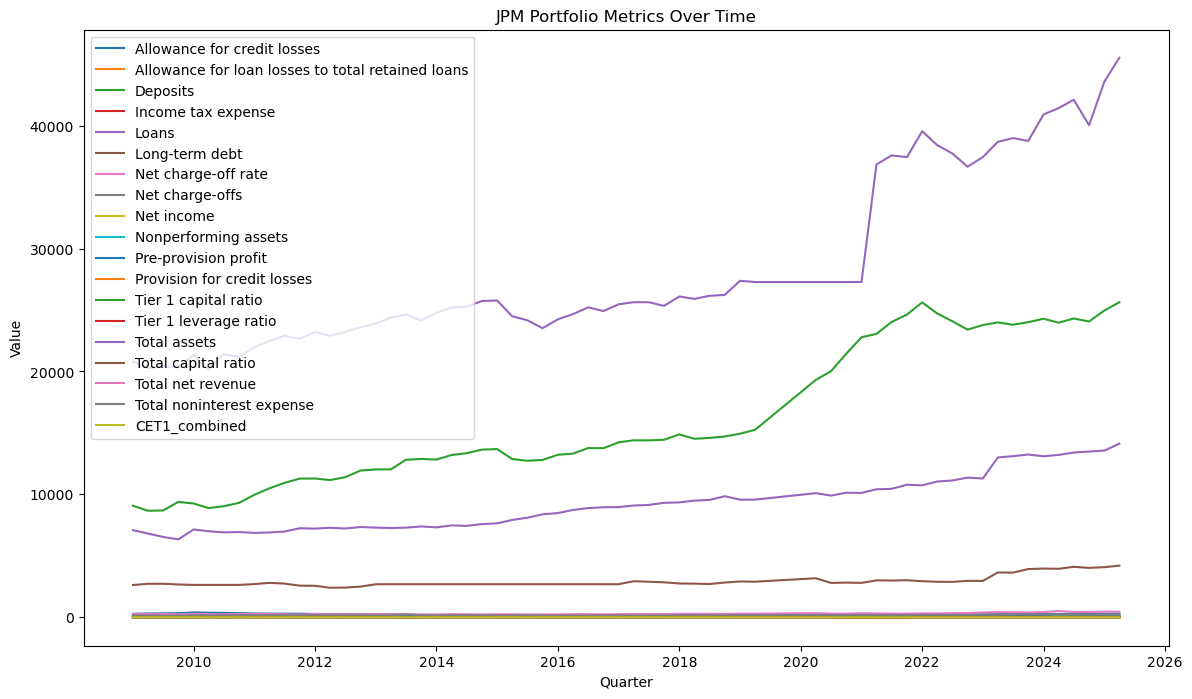

In [32]:
## Time series plots

plt.figure(figsize=(14,8))

for col in df_wide.columns:
    plt.plot(df_wide.index, df_wide[col], label=col)

plt.legend()
plt.title("JPM Portfolio Metrics Over Time")
plt.xlabel("Quarter")
plt.ylabel("Value")
plt.show()

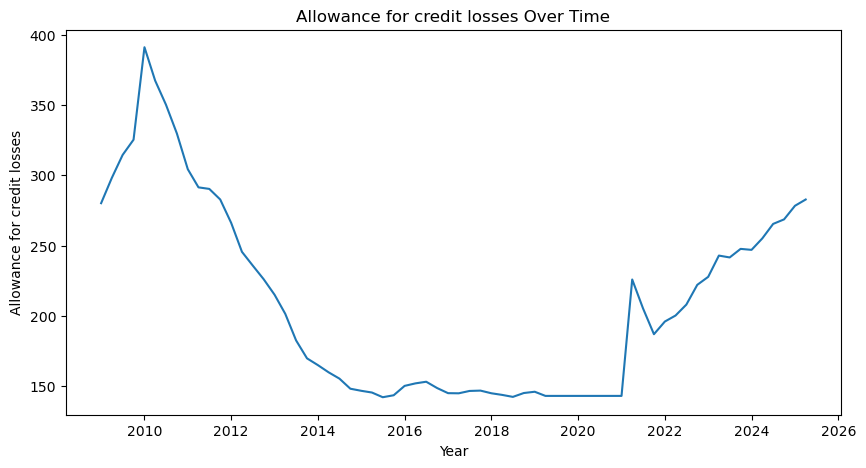

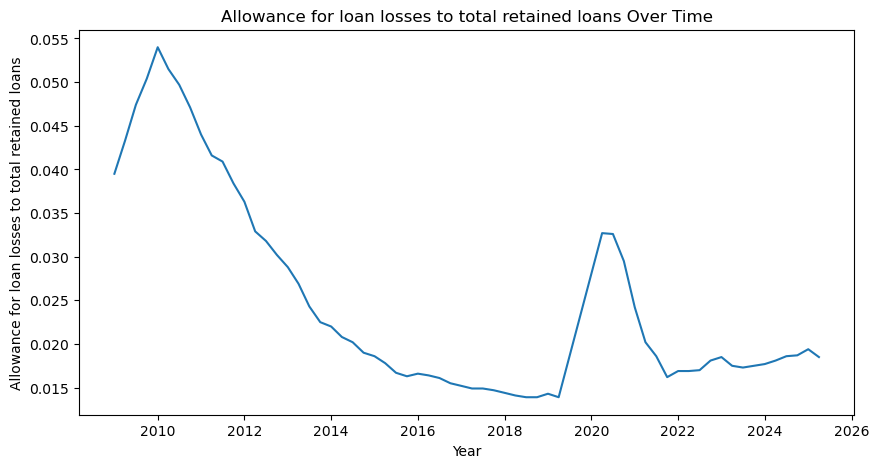

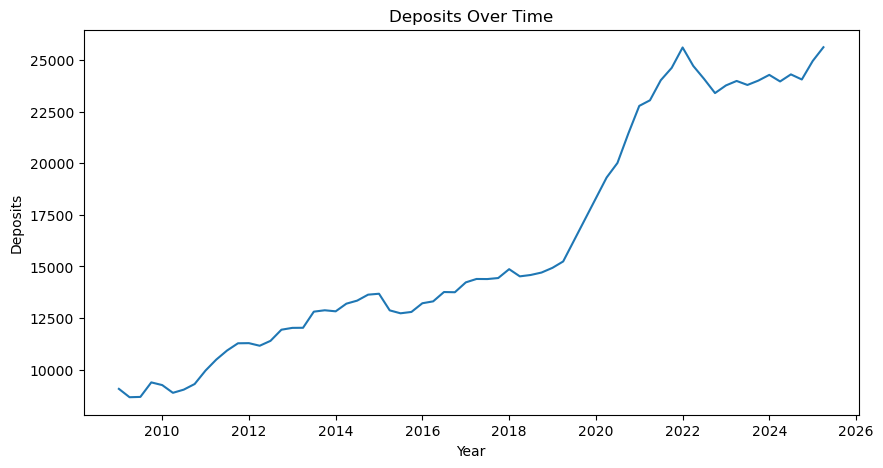

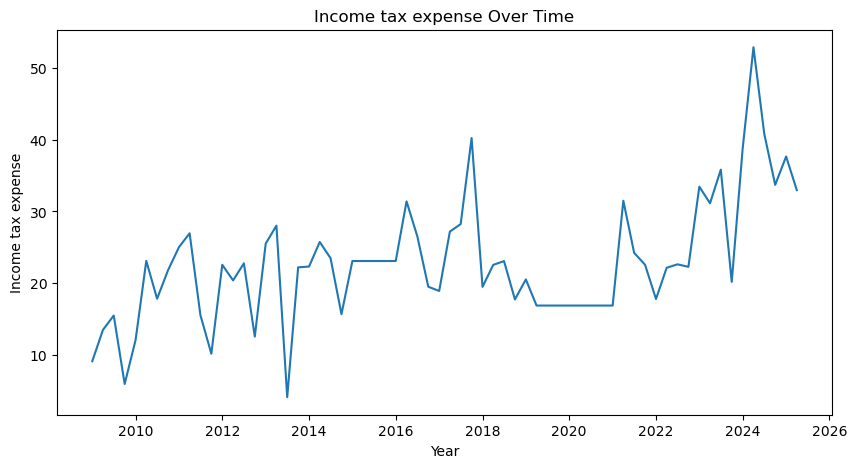

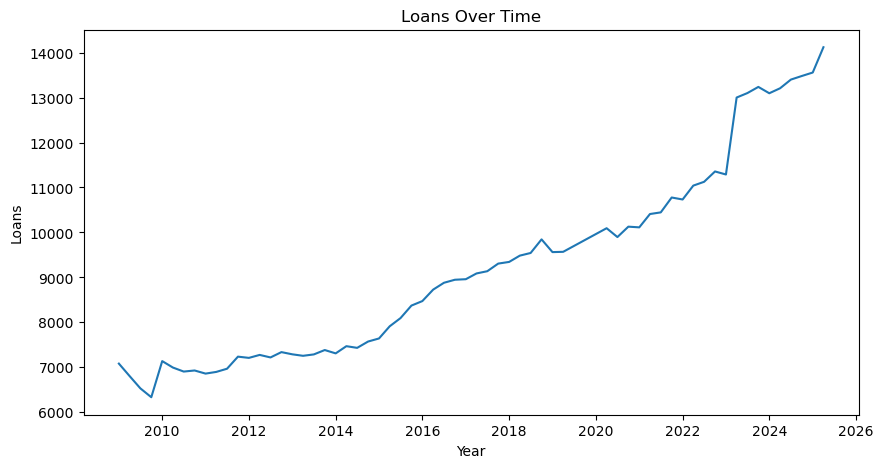

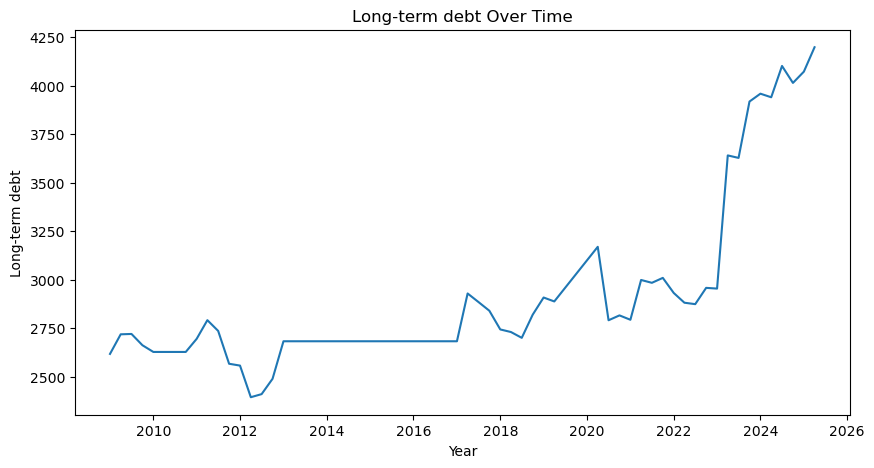

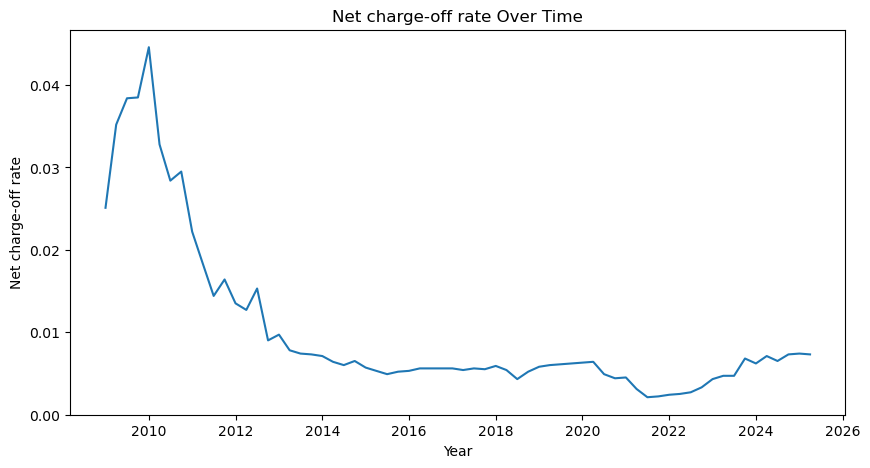

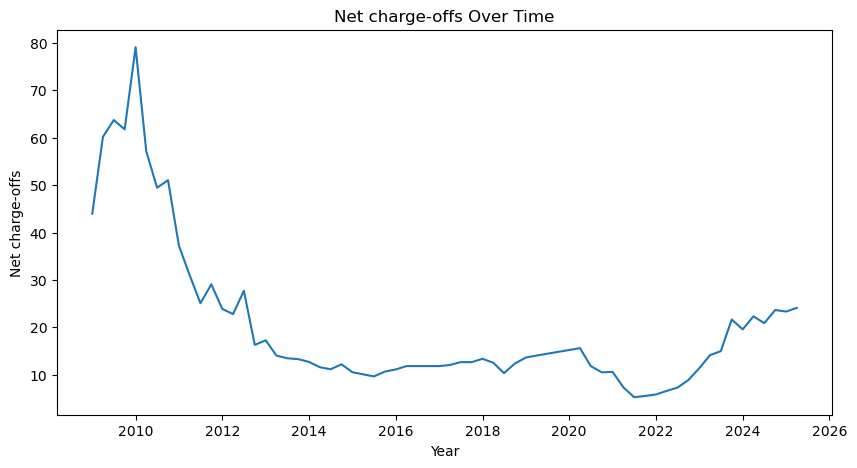

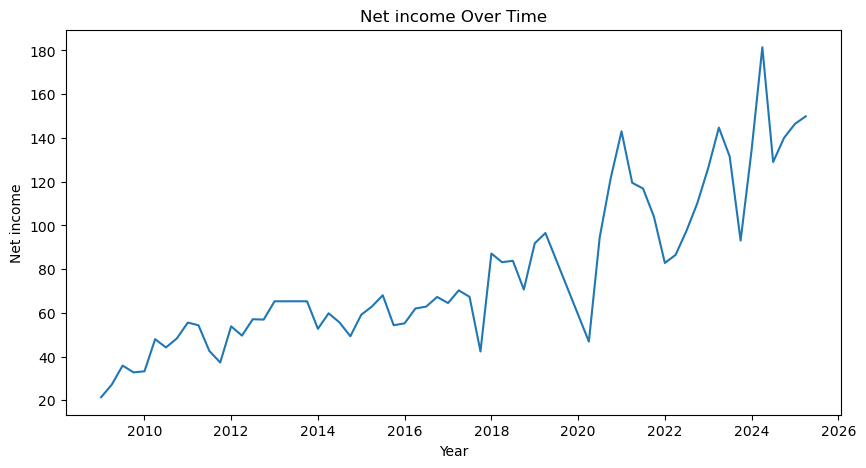

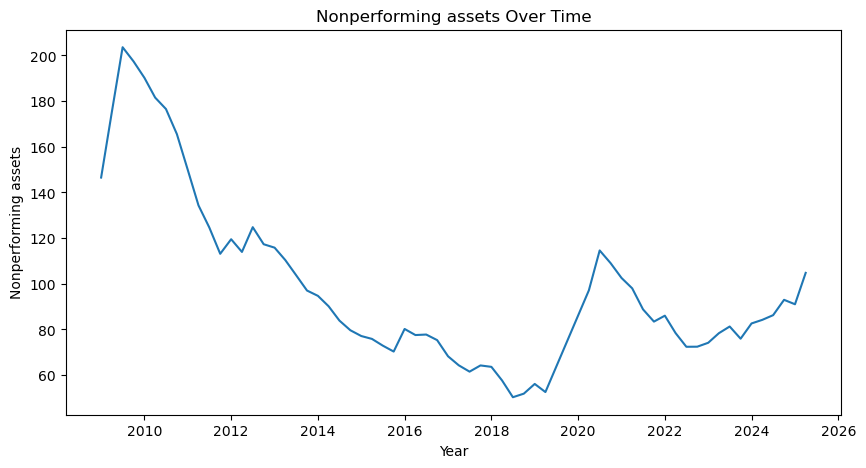

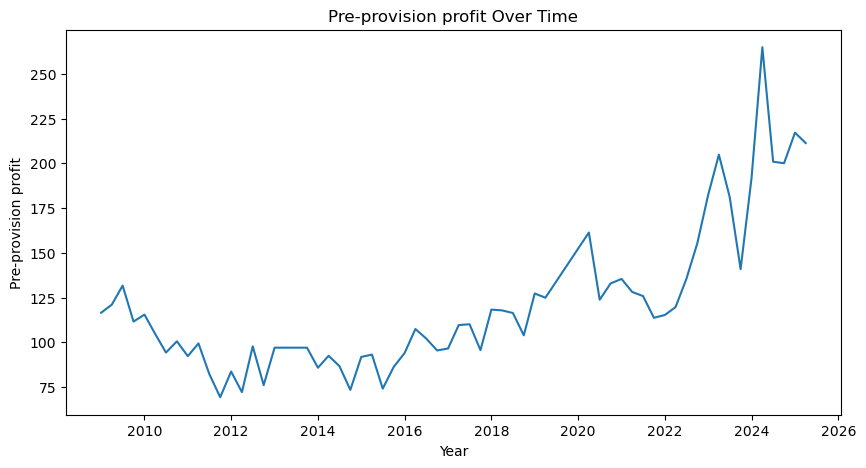

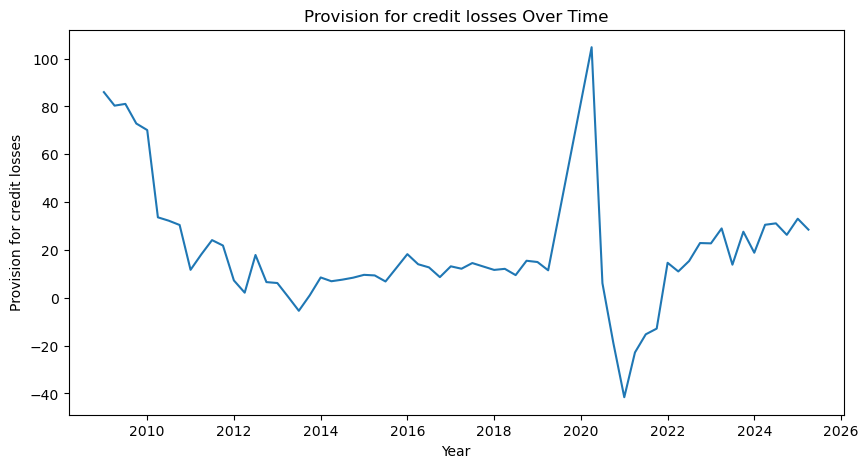

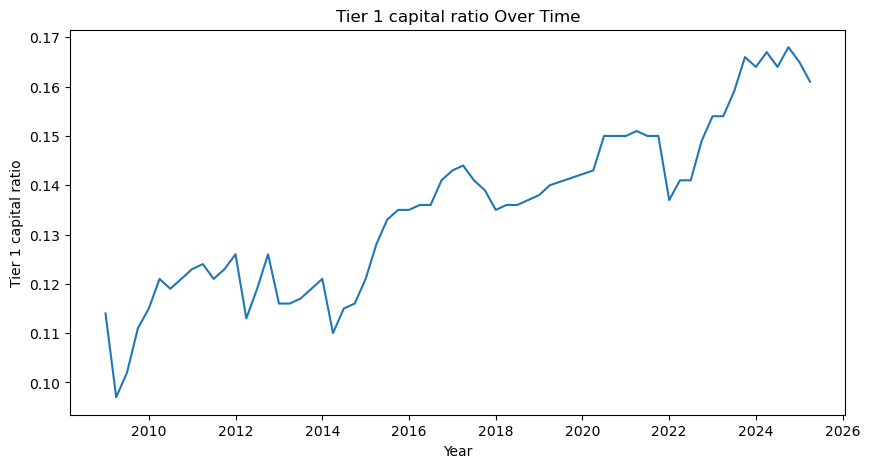

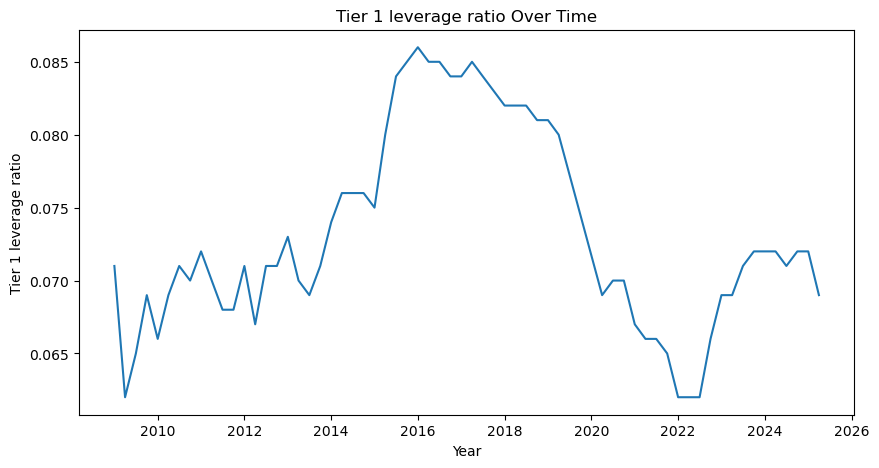

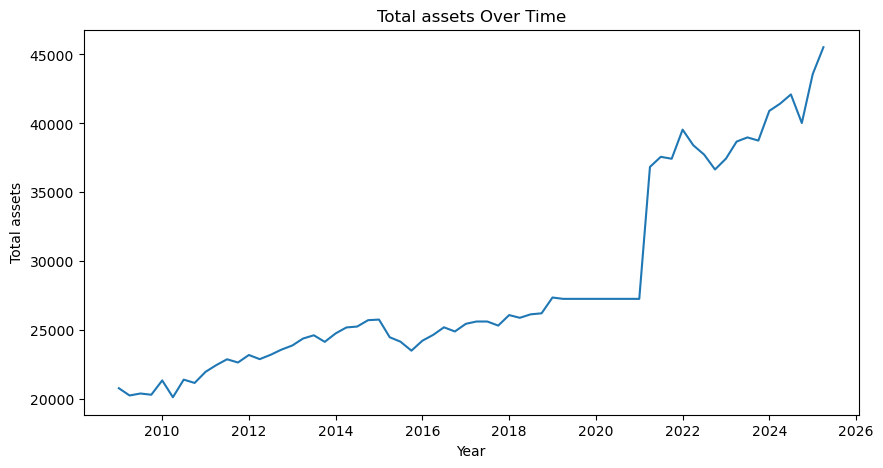

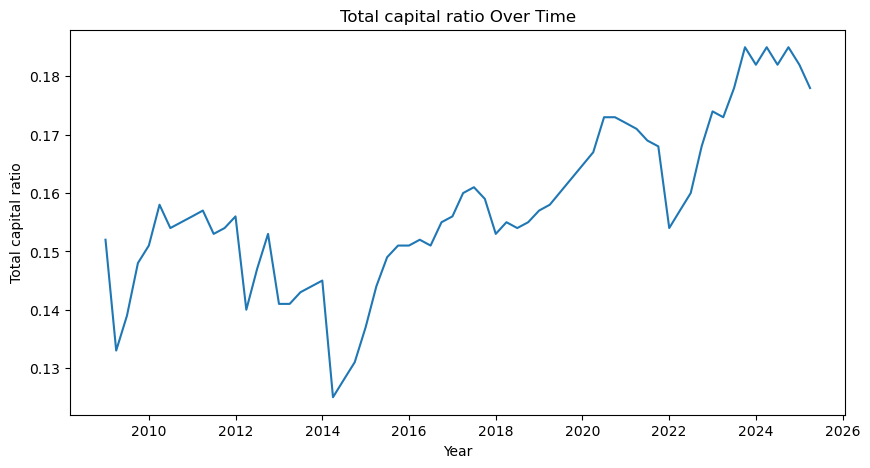

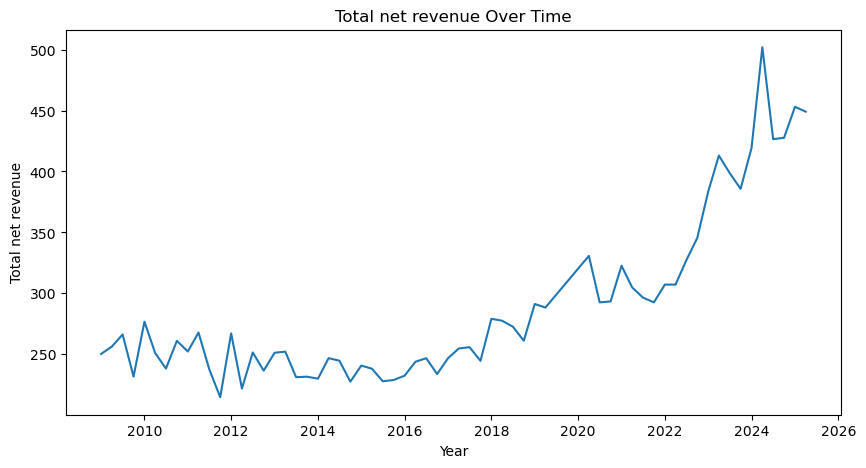

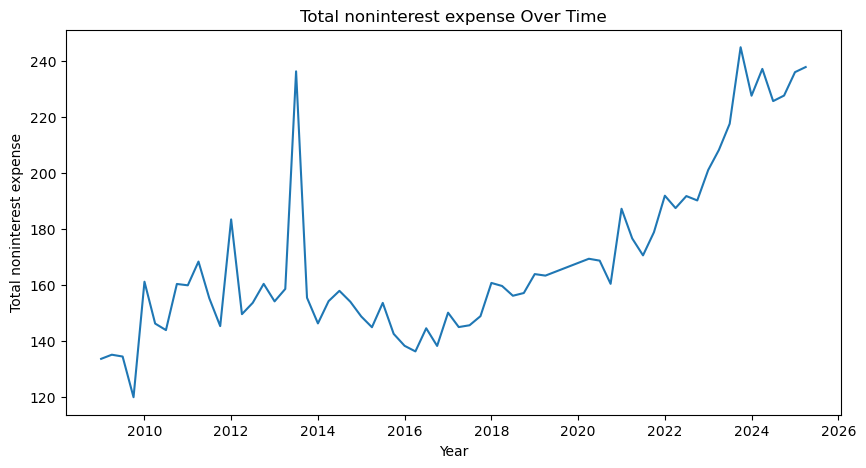

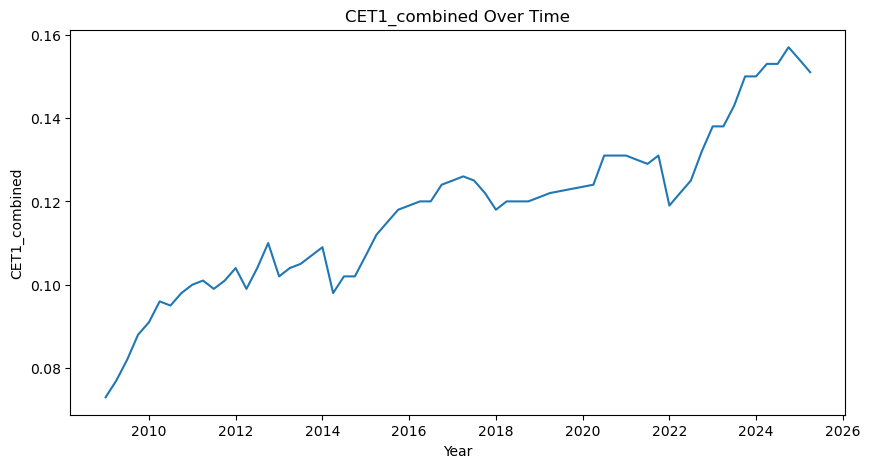

In [34]:
## Individual metric plots

for col in df_wide.columns:
    plt.figure(figsize=(10,5))
    plt.plot(df_wide.index, df_wide[col])
    plt.title(f"{col} Over Time")
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.show()

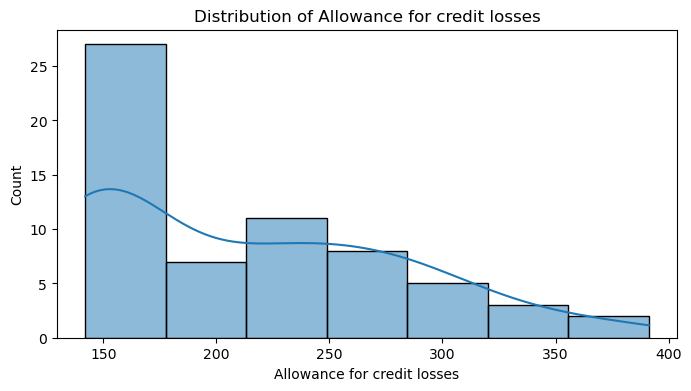

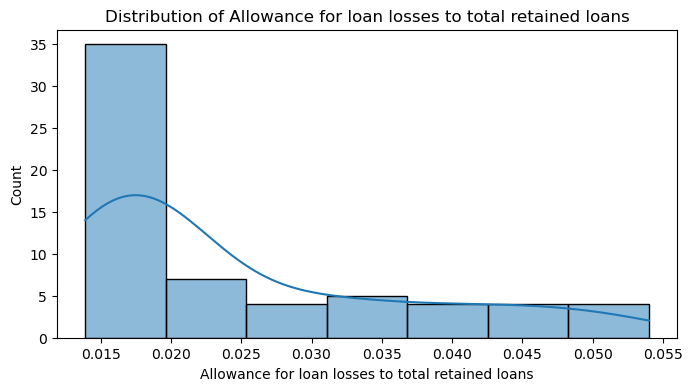

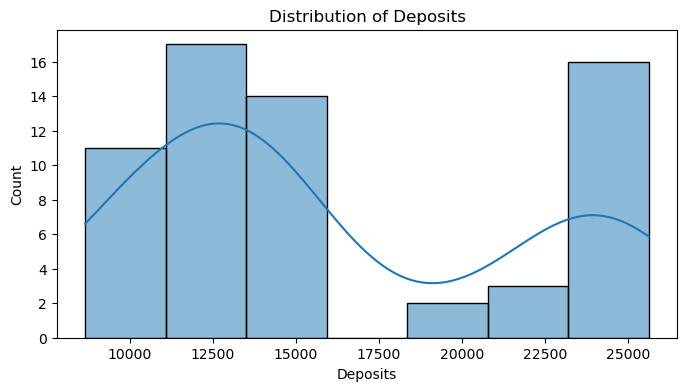

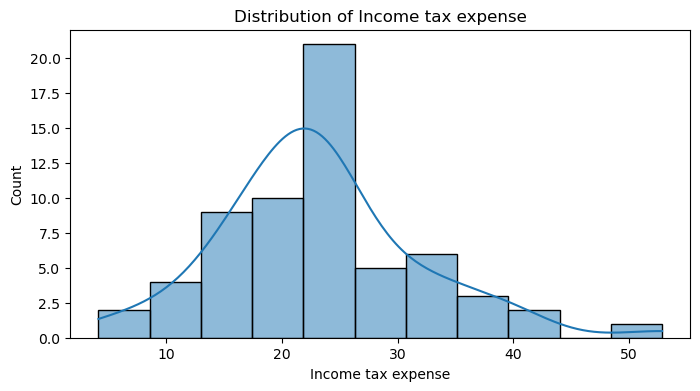

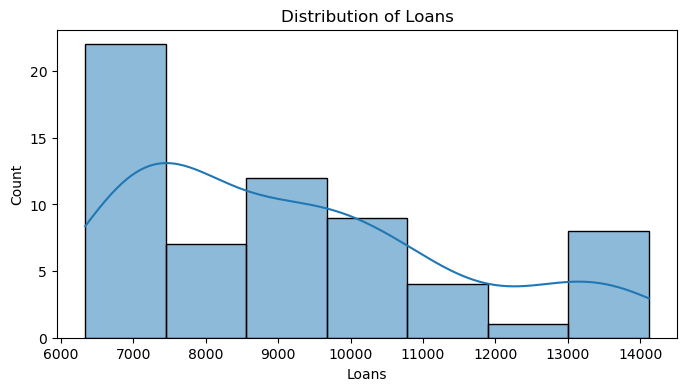

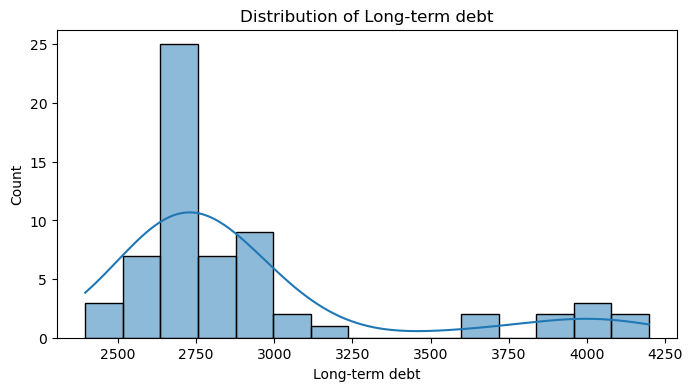

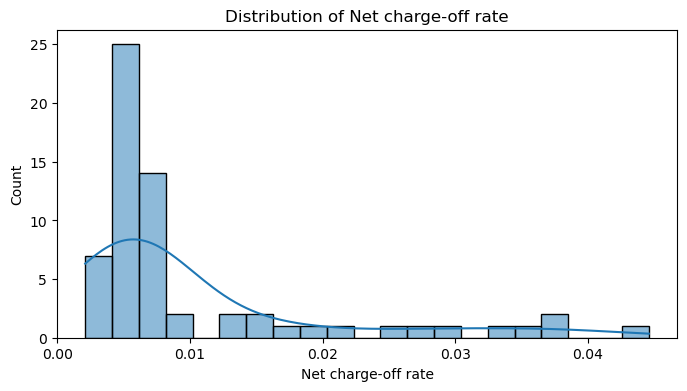

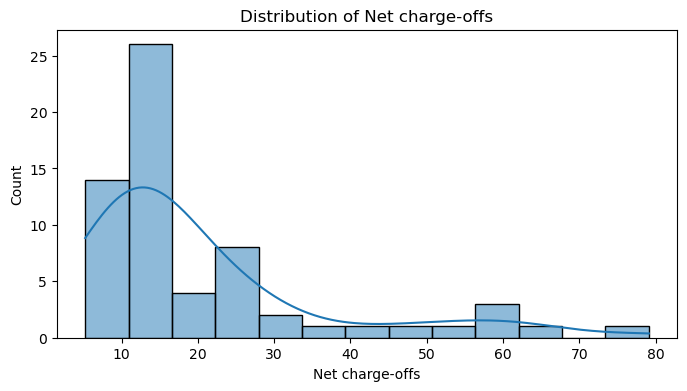

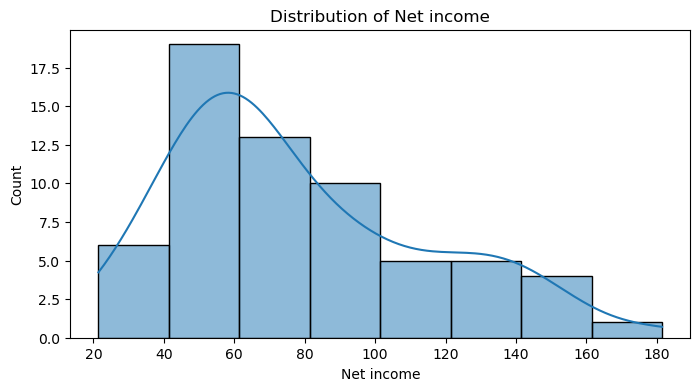

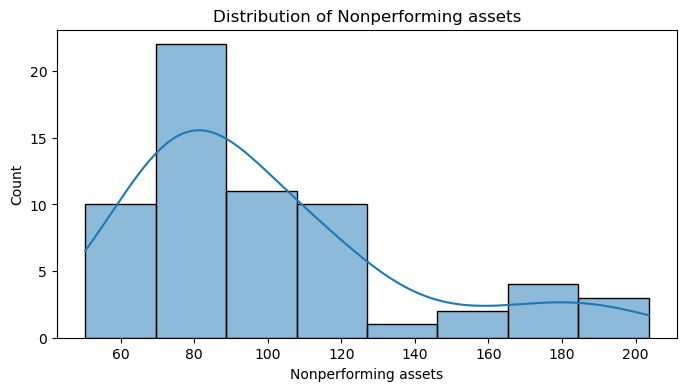

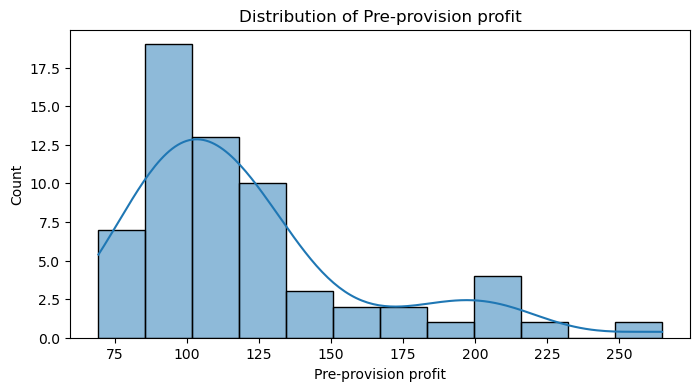

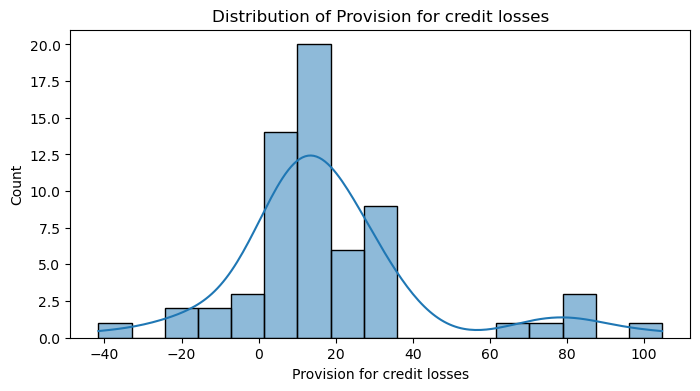

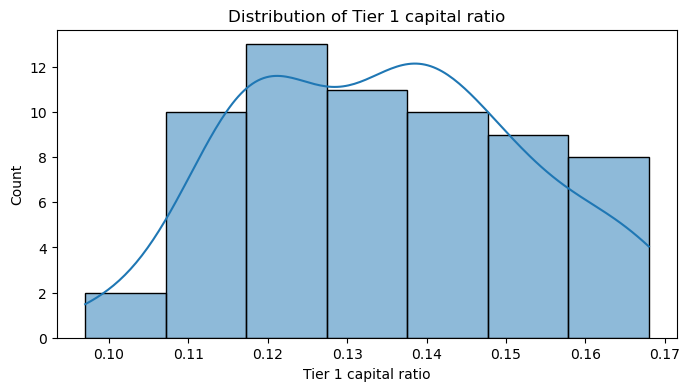

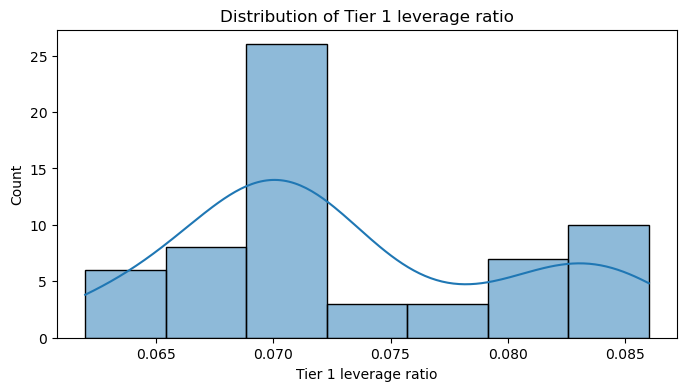

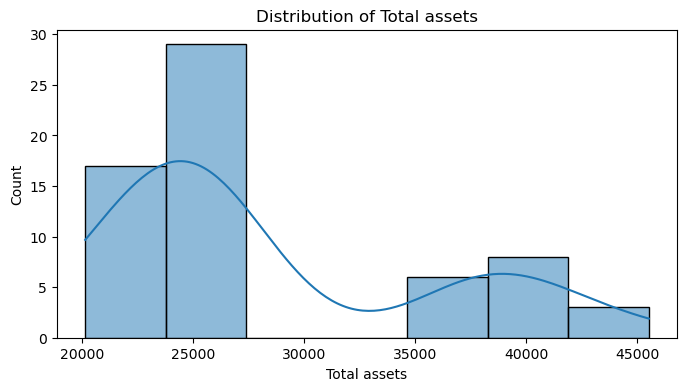

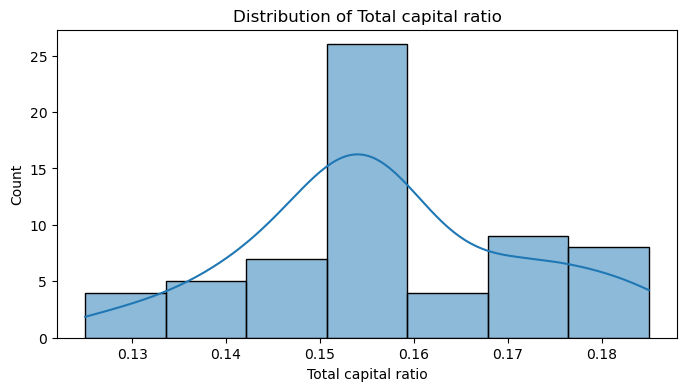

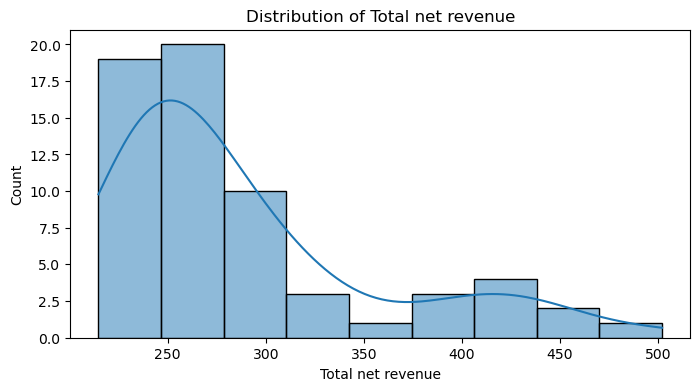

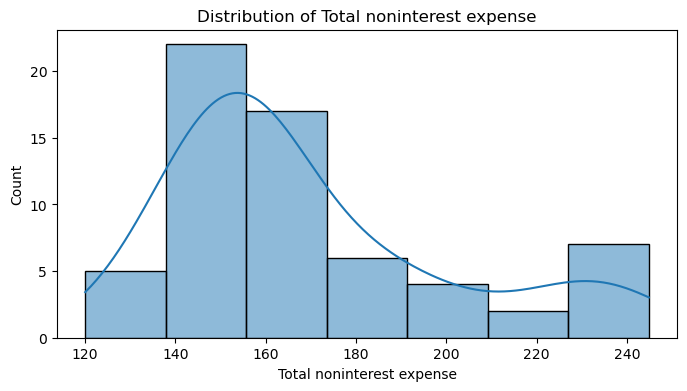

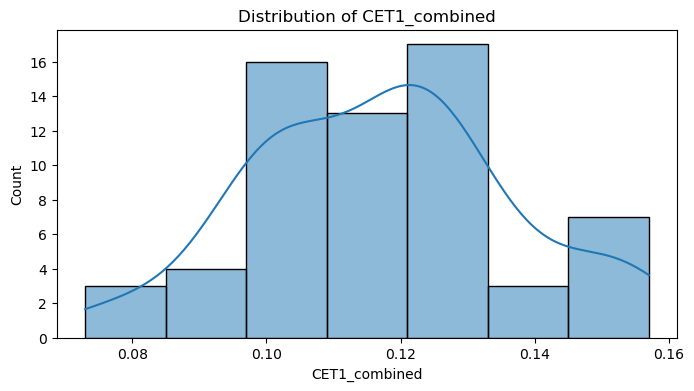

In [35]:
## Distribution Plots

for col in df_wide.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df_wide[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

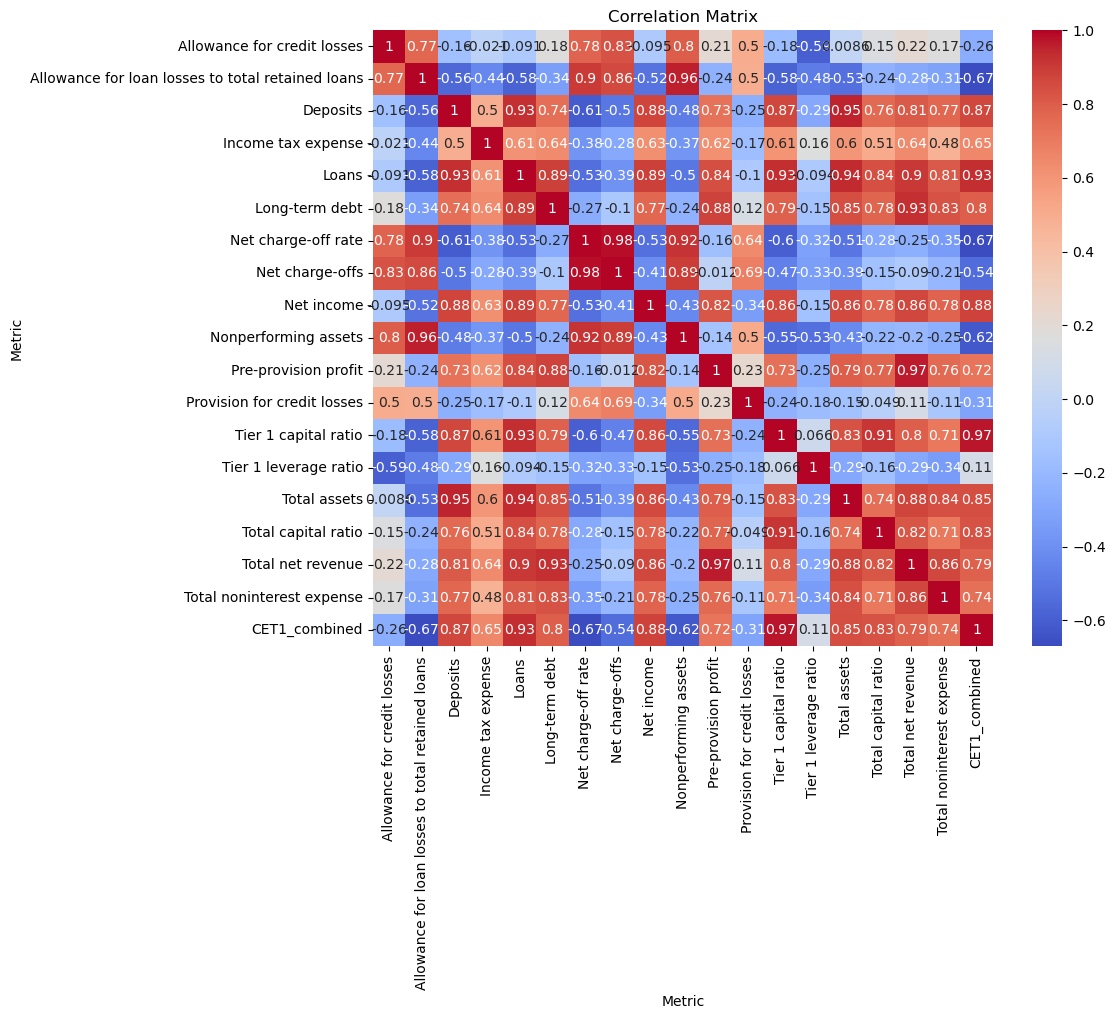

In [36]:
## Correlation matrix

corr_matrix = df_wide.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
## Lag creation

lags = [1, 2, 4]

for col in df_wide.columns:
    for lag in lags:
        df_wide[f"{col}_lag{lag}"] = df_wide[col].shift(lag)

df_wide_lagged = df_wide.dropna()

In [ ]:
## QoQ changes

df_growth = df_wide.pct_change()

plt.figure(figsize=(12,6))
for col in df_growth.columns:
    plt.plot(df_growth.index, df_growth[col], label=col)

plt.legend()
plt.title("Quarter-over-Quarter % Change")
plt.show()